In [1]:
import time
from picamera2 import Picamera2, Preview
from picamera2.controls import Controls
import cv2
import numpy as np
import matplotlib.pyplot as plt
import RPi.GPIO as GPIO
from time import sleep
import tifffile

In [2]:
led = 23
GPIO.setmode(GPIO.BCM)
GPIO.setup(led, GPIO.OUT)

picam2 = Picamera2()

# Set camera controls
controls = {"ExposureTime": 4000000, #microseconds
            "AnalogueGain":1.0, # 1 = ISO 100
            "AeEnable": False, # Auto exposure and Gain
            "AwbEnable": False,# Auto white Balance
            "FrameDurationLimits": (114,239000000)} #Min/Max frame duration

# Setup config parameters
preview_config = picam2.create_preview_configuration(raw={"size": picam2.sensor_resolution, "format": "SBGGR12",},
                                                     controls = controls) 
print(preview_config)

{'use_case': 'preview', 'transform': <libcamera.Transform 'identity'>, 'colour_space': <libcamera.ColorSpace 'sYCC'>, 'buffer_count': 4, 'queue': True, 'main': {'format': 'XBGR8888', 'size': (640, 480)}, 'lores': None, 'raw': {'format': 'SBGGR12', 'size': (4056, 3040)}, 'controls': {'NoiseReductionMode': <NoiseReductionModeEnum.Minimal: 3>, 'FrameDurationLimits': (114, 239000000), 'ExposureTime': 4000000, 'AnalogueGain': 1.0, 'AeEnable': False, 'AwbEnable': False}, 'display': 'main', 'encode': 'main'}


/tmp/ipykernel_5781/2575868153.py:3: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(led, GPIO.OUT)
[1:34:31.158931181] [5781]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70
[1:34:31.232233301] [5796]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/imx477@1a to Unicam device /dev/media1 and ISP device /dev/media3


[1:34:33.647247823] [5781]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888 (1) 4056x3040-SBGGR12
[1:34:33.648149136] [5796]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/imx477@1a - Selected sensor format: 4056x3040-SBGGR12_1X12 - Selected unicam format: 4056x3040-BG12


{'FocusFoM': 3692, 'ExposureTime': 3999942, 'ColourTemperature': 4000, 'SensorTimestamp': 5682424757000, 'ScalerCrop': (2, 0, 4053, 3040), 'SensorBlackLevels': (4096, 4096, 4096, 4096), 'DigitalGain': 1.000014305114746, 'ColourGains': (2.510904550552368, 1.656680941581726), 'SensorTemperature': 23.0, 'Lux': 1.8589563369750977, 'FrameDuration': 4000571, 'AeLocked': False, 'ColourCorrectionMatrix': (2.1575498580932617, -1.1039637327194214, -0.05359601974487305, -0.3457588851451874, 1.6122934818267822, -0.2665446400642395, -0.02813815139234066, -0.7009111046791077, 1.7290493249893188), 'AnalogueGain': 1.0}


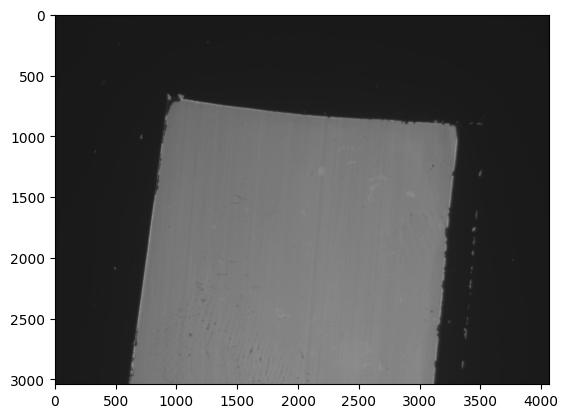

In [3]:
picam2.start_preview(Preview.QTGL)
picam2.configure(preview_config)

picam2.start() # Start Camera
 
time.sleep(2)

GPIO.output(led, GPIO.HIGH) # Turn on LED
time.sleep(1)

#Capture image in unpacked RAW format 12bit dynamic range (16bit array)
raw = picam2.capture_array("raw").view(np.uint16)

time.sleep(1)
GPIO.output(led, GPIO.LOW) # Turn off LED

#print(picam2.stream_configuration("raw"))
print(picam2.capture_metadata())

picam2.stop_preview()

plt.imshow(raw, cmap="gray")

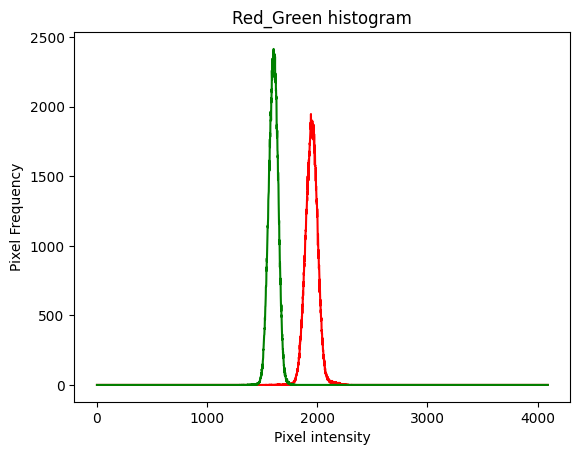

Histogram Succes


In [4]:
center_crop = raw[1000:2000, 2000:3000]

#Get color channels in bayer order (BGGR)
red = center_crop[1::2,1::2]
green1 = center_crop[0::2,1::2]
green2 = center_crop[1::2,0::2]
green = np.add(green1,green2)/2

#Make histogram for red and green channel # Set camera controls to have good pixel saturation
Colors=("red","green")
Channel_ids=(red,green)
for channel_id, c in zip(Channel_ids,Colors):
    histogram, bin_edges=np.histogram(channel_id,bins=4095, range=(0,4095))
    plt.plot(bin_edges[0:-1],histogram,color=c)
plt.title("Red_Green histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Pixel Frequency")
plt.show()
print("Histogram Succes")